In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import scanpy as sc

In [3]:
DATASET_NAME = "BM-CITE"
BASE_DATA_DIR = os.path.join("..", "datasets", "data", "processed")  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
from utils.data_utils import dataset_config, load_dataset

_, data_dict = load_dataset(DATASET_NAME, BASE_DATA_DIR, DEVICE)

c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
import torch
print(torch.__version__)          # PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # CUDA version (e.g., 11.7)

2.5.1
True
12.4


In [14]:
import scanpy as sc

modalities = dataset_config[DATASET_NAME]["modalities"]
print(modalities)

data = {}

for modality in modalities:
    data[modality] = sc.read_h5ad(f"./../datasets/data/processed/{DATASET_NAME}_{modality}.h5ad")

cell_metadata = data[modalities[0]].obs.copy()

data

['ADT', 'RNA']


{'ADT': AnnData object with n_obs × n_vars = 30672 × 25
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lane', 'donor', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_apca'
     varm: 'APCA',
 'RNA': AnnData object with n_obs × n_vars = 30672 × 2000
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lane', 'donor', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_pca'
     varm: 'PCs'}

In [15]:
for m in modalities:
    print(f"Available keys for {m}:", data[m].obsm.keys())

Available keys for ADT: KeysView(AxisArrays with keys: X_apca)
Available keys for RNA: KeysView(AxisArrays with keys: X_pca)


In [16]:
import torch

# processed = {m: {'x': torch.tensor(data[m].X, dtype=torch.float)} for m in modalities}
# processed

processed = {}
for m in modalities:
    rep = data[m].obsm.get('X_glue', data[m].X)
    processed[m] = {'x': torch.tensor(rep, dtype=torch.float)}

# processed - for the match data with precomputed latent representations

In [17]:
from torch_geometric.data import HeteroData

# (1) Assign attributes after initialization,
hetero_data = HeteroData(processed)
hetero_data['cell'].x = torch.cat([hetero_data[m].x for m in modalities], dim=1)
hetero_data['cell'].metadata = cell_metadata 
hetero_data

HeteroData(
  ADT={ x=[30672, 25] },
  RNA={ x=[30672, 2000] },
  cell={
    x=[30672, 2025],
    metadata=                      orig.ident  nCount_RNA  nFeature_RNA       lane   donor  \
a_AAACCTGAGCTTATCG-1           0      7546.0          2136  HumanHTO4  batch1   
a_AAACCTGAGGTGGGTT-1           0      1029.0           437  HumanHTO1  batch1   
a_AAACCTGAGTACATGA-1           0      1111.0           429  HumanHTO5  batch1   
a_AAACCTGCAAACCTAC-1           0      2741.0           851  HumanHTO3  batch1   
a_AAACCTGCAAGGTGTG-1           0      2099.0           843  HumanHTO2  batch1   
...                          ...         ...           ...        ...     ...   
b_TTTGTCATCCGAGCCA-1           1      3000.0           895  HumanHTO8  batch2   
b_TTTGTCATCCGTAGGC-1           1      2230.0           649  HumanHTO9  batch2   
b_TTTGTCATCCTCGCAT-1           1      4259.0          1457  HumanHTO6  batch2   
b_TTTGTCATCGCCGTGA-1           1      2648.0           733  HumanHTO3  batch2   
b_

In [19]:
from utils.graph_utils import (
    calculate_modality_jaccard,
    plot_degree_distributions,
    plot_modality_umaps
)
import matplotlib.pyplot as plt

def visualize_individual_metrics(hetero_data, data_dict, config):
    """Visualize per-modality graph metrics using utils"""
    modalities = config["modalities"]
    
    # Calculate and print Jaccard scores
    jaccard_results = {
        m: calculate_modality_jaccard(hetero_data['cell', m, 'cell'].edge_index)
        for m in modalities
    }
    print("Neighborhood Consistency Scores:")
    for mod, score in jaccard_results.items():
        print(f"- {mod}: {score:.3f}")
    
    # Plot distributions
    plot_degree_distributions(hetero_data, modalities)

    # Generate UMAP plots for each modality.
    modality_figs = plot_modality_umaps(data_dict, modalities)
    
    # Display each figure individually:
    for modality, fig in modality_figs.items():
        fig.show()
    
    plt.show()

visualize_individual_metrics(hetero_data, data_dict, dataset_config[DATASET_NAME]) 

AttributeError: 'EdgeStorage' object has no attribute 'edge_index'

In [20]:
from torch_geometric.nn import knn_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hetero_data = hetero_data.to(device)

for m in modalities:
    hetero_data['cell', m, 'cell'].edge_index = knn_graph(
        hetero_data[m].x,
        k=10,
        cosine=True,
        num_workers=16
    )

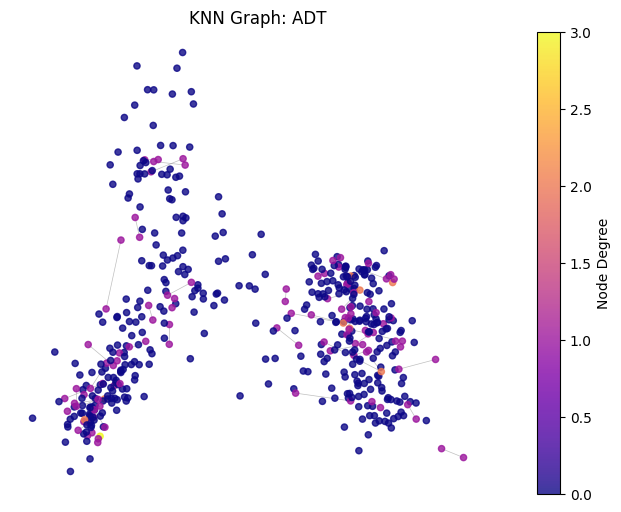

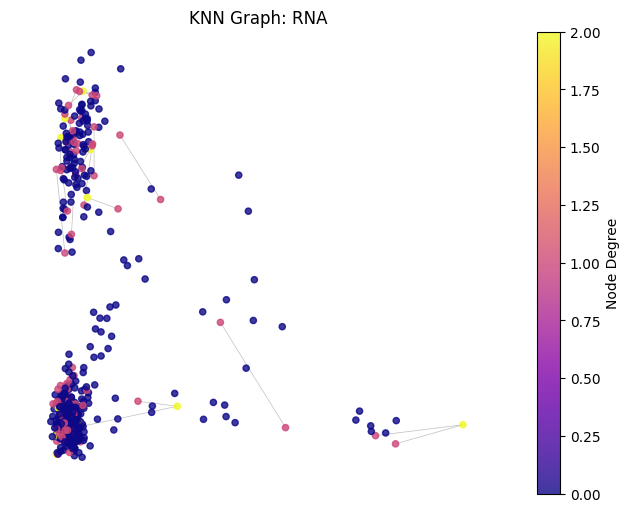

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.decomposition import PCA

def visualize_knn_graph_for_modality(hetero_data, modality, sample_size=500):
    """
    Visualizes the KNN graph for a specific modality.
    
    Parameters:
      hetero_data: PyG HeteroData object.
      modality: str, modality name (e.g., 'ADT', 'RNA').
      sample_size: int, number of nodes to sample for visualization (if less than total).
    """
    # Extract modality-specific node features
    features = hetero_data[modality].x.cpu().detach().numpy()
    num_nodes = features.shape[0]
    
    # Reduce dimensions for visualization using PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    # Get KNN edge_index from modality-specific edges
    edge_index = hetero_data['cell', modality, 'cell'].edge_index.cpu().numpy()
    
    # Subsample nodes for clarity if dataset is large
    if sample_size < num_nodes:
        subset_idx = np.sort(np.random.choice(num_nodes, sample_size, replace=False))
        features_2d = features_2d[subset_idx]
        
        # Filter edges where both nodes are in the subset
        mask = np.isin(edge_index[0], subset_idx) & np.isin(edge_index[1], subset_idx)
        edge_index = edge_index[:, mask]
        
        # Remap original indices to subset indices
        mapping = {old: new for new, old in enumerate(subset_idx)}
        edge_index = np.vectorize(mapping.get)(edge_index)
        
        n_nodes = sample_size
    else:
        n_nodes = num_nodes

    # Build a NetworkX graph
    G = nx.Graph()
    for i in range(n_nodes):
        G.add_node(i, pos=features_2d[i])
    
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        G.add_edge(int(src), int(dst))
    
    pos = nx.get_node_attributes(G, 'pos')
    
    # Compute node degree for coloring
    degrees = dict(G.degree())
    node_colors = [degrees[node] for node in G.nodes()]
    
    # Plot the graph
    plt.figure(figsize=(8, 6))
    
    # Draw nodes and store the object
    nodes = nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, cmap=plt.cm.plasma, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray', alpha=0.5)
    
    plt.title(f"KNN Graph: {modality}")
    plt.axis('off')
    
    # Associate the colorbar with the nodes scatter plot
    cbar = plt.colorbar(nodes)
    cbar.set_label('Node Degree')
    
    plt.show()

# Visualize KNN graphs for each modality
for modality in modalities:
    visualize_knn_graph_for_modality(hetero_data, modality, sample_size=500)

In [13]:
output_dir = os.path.join(BASE_DATA_DIR, DATASET_NAME)
os.makedirs(output_dir, exist_ok=True)

# Move data to CPU and save
hetero_data = hetero_data.cpu()
output_path = os.path.join(output_dir, f"{DATASET_NAME}_processed.pt")
torch.save(hetero_data, output_path)

print(f"Saved processed data to {output_path}")

Saved processed data to ..\datasets\data\processed\BM-CITE\BM-CITE_processed.pt


In [10]:
output_path = os.path.join(os.path.join(BASE_DATA_DIR, DATASET_NAME), f"{DATASET_NAME}_processed.pt")
loaded_data = torch.load(output_path)
hetero_data = loaded_data.to(DEVICE)  # Move back to GPU if needed

C:\Users\sonia\AppData\Local\Temp\ipykernel_15952\2055880503.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(output_path)


In [30]:
import torch
from torch_geometric.loader import NeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hetero_data = hetero_data.to(device)

num_cells = hetero_data['cell'].x.size(0)
cell_idx = torch.arange(num_cells, device=device)

neighbor_loader = NeighborLoader(
    hetero_data,
    num_neighbors={
        ('cell', m, 'cell'): [5, 5] for m in modalities
    },
    input_nodes=('cell', cell_idx),
    batch_size=256 # choose an appropriate batch size for your memory constraints
)

for batch in neighbor_loader:
    print(batch)

HeteroData(
  ADT={
    x=[0, 25],
    n_id=[0],
  },
  RNA={
    x=[0, 2000],
    n_id=[0],
  },
  cell={
    x=[14927, 2025],
    metadata=                      orig.ident  nCount_RNA  nFeature_RNA       lane   donor  \
a_AAACCTGAGCTTATCG-1           0      7546.0          2136  HumanHTO4  batch1   
a_AAACCTGAGGTGGGTT-1           0      1029.0           437  HumanHTO1  batch1   
a_AAACCTGAGTACATGA-1           0      1111.0           429  HumanHTO5  batch1   
a_AAACCTGCAAACCTAC-1           0      2741.0           851  HumanHTO3  batch1   
a_AAACCTGCAAGGTGTG-1           0      2099.0           843  HumanHTO2  batch1   
...                          ...         ...           ...        ...     ...   
b_TTTGTCATCCGAGCCA-1           1      3000.0           895  HumanHTO8  batch2   
b_TTTGTCATCCGTAGGC-1           1      2230.0           649  HumanHTO9  batch2   
b_TTTGTCATCCTCGCAT-1           1      4259.0          1457  HumanHTO6  batch2   
b_TTTGTCATCGCCGTGA-1           1      2648.0     

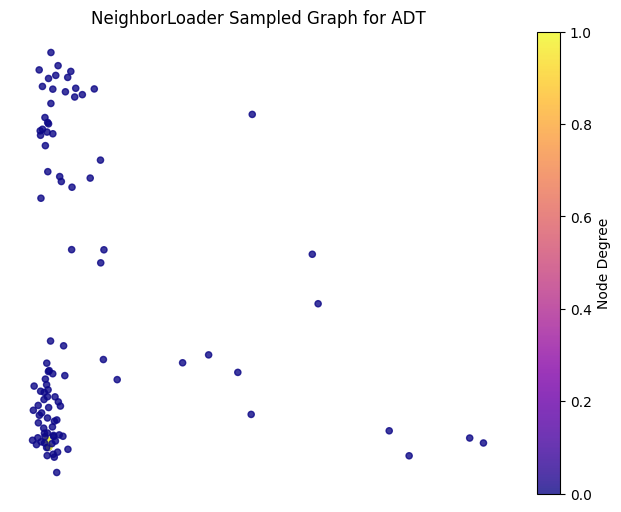

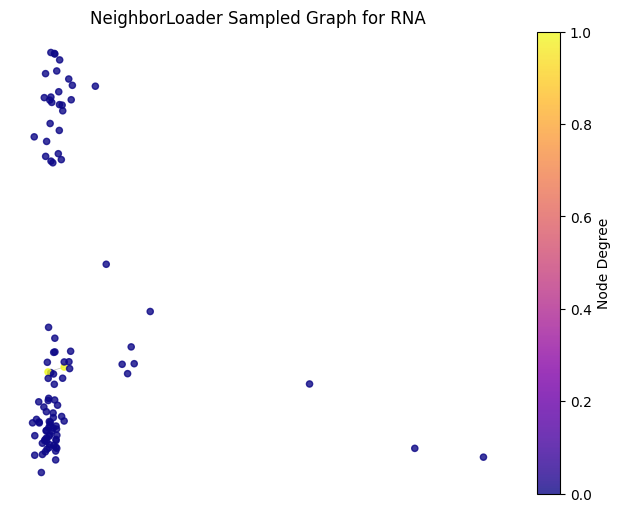

In [23]:
def visualize_neighbor_batch(batch, modality, sample_size=100):
    """
    Visualizes the subgraph sampled by NeighborLoader for a specific modality.
    
    Parameters:
      batch: A single mini-batch from NeighborLoader.
      modality: str, modality name (e.g., 'ADT', 'RNA').
      sample_size: int, maximum number of nodes to plot (for clarity).
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Extract edges and node features from the batch.
    # We assume cell node features are in batch['cell'].x
    node_features = batch['cell'].x.cpu().detach().numpy()
    num_nodes = node_features.shape[0]
    
    # Apply PCA to reduce node features to 2D.
    pca = PCA(n_components=2)
    node_2d = pca.fit_transform(node_features)
    
    # Get the edge_index for the modality
    edge_index = batch['cell', modality, 'cell'].edge_index.cpu().numpy()  # shape: [2, num_edges]
    
    # Subsample nodes if needed.
    if sample_size < num_nodes:
        subset_idx = np.sort(np.random.choice(num_nodes, sample_size, replace=False))
        node_2d = node_2d[subset_idx]
        
        # Filter edges where both nodes are in the subset.
        mask = np.isin(edge_index[0], subset_idx) & np.isin(edge_index[1], subset_idx)
        filtered_edges = edge_index[:, mask]
        
        # Check if filtered_edges is nonempty.
        if filtered_edges.size > 0:
            mapping = {old: new for new, old in enumerate(subset_idx)}
            # Explicitly set otypes to int to avoid the error.
            edge_index_sample = np.vectorize(mapping.get, otypes=[int])(filtered_edges)
        else:
            edge_index_sample = filtered_edges  # Empty array.
        n_nodes = sample_size
    else:
        edge_index_sample = edge_index
        n_nodes = num_nodes
    
    # Build the graph.
    G = nx.Graph()
    for i in range(n_nodes):
        G.add_node(i, pos=node_2d[i])
    for i in range(edge_index_sample.shape[1]):
        src, dst = edge_index_sample[:, i]
        G.add_edge(int(src), int(dst))
    
    pos = nx.get_node_attributes(G, 'pos')
    
    # Compute node degrees for coloring.
    degrees = dict(G.degree())
    node_colors = [degrees[node] for node in G.nodes()]
    
    # Plot the graph.
    plt.figure(figsize=(8, 6))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, cmap=plt.cm.plasma, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray', alpha=0.5)
    plt.title(f"NeighborLoader Sampled Graph for {modality}")
    plt.axis("off")
    plt.colorbar(nodes, label='Node Degree')
    plt.show()

# Visualize for each modality from the first batch.
for batch in neighbor_loader:
    for modality in modalities:
        visualize_neighbor_batch(batch, modality, sample_size=100)
    break  # Visualize only the first batch.


In [17]:
from model.model import HeteroGraphAE, GraphAELightningModule
# Hyperparameters.
in_channels = hetero_data['cell'].x.size(1)
hidden_channels = 512
latent_channels = 512   # Dimensionality of the latent space.
num_layers = 2
learning_rate = 1e-4
n_epochs = 1 # change to 500 for full training

# Instantiate the Lightning module.
model = GraphAELightningModule(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    latent_channels=latent_channels,
    modalities=modalities,
    num_layers=num_layers,
    learning_rate=learning_rate,
    total_epochs=n_epochs,
    warmup_epochs=3,
    num_clusters=20,
    clustering_weight=.01
)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',         # monitor your training loss
    dirpath='checkpoints',        # directory to save checkpoints
    filename='graph_ae-{epoch:02d}-{train_loss:.2f}',
    save_top_k=1,                 # save the best model
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='train_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)

trainer = Trainer(
    max_epochs=n_epochs,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)
trainer.fit(model, train_dataloaders=neighbor_loader)


In [24]:
from model.model import GraphAELightningModule

checkpoint_path = r"C:/Users/sonia/Documents/University/Cambridge/L65/Multi Omics Integration Project/MultiOmicsIntegration/evaluation/checkpoints/BM-CITE-graph_ae-epoch=140-train_loss=0.09.ckpt"

model = GraphAELightningModule.load_from_checkpoint(
    checkpoint_path,
    in_channels=hetero_data['cell'].x.size(1),
    hidden_channels=512,
    latent_channels=512,      
    modalities=modalities,    
    num_layers=2,
    learning_rate=0.0001,
    total_epochs=500,
    warmup_epochs=3,
    num_clusters=20,
    clustering_weight=0.01,
    strict=False             
)


In [ ]:
# Inference on full data:
model.eval()
with torch.no_grad():
    # Move data to the same device as the model.
    hetero_data = hetero_data.to(model.device)
    z = model(hetero_data)
    # For example, reconstruct edge probabilities using one set of edges.
    pos_edge_index = list(hetero_data.edge_index_dict.values())[0]
    pred_edge_probs = model.model.decode(z, pos_edge_index)
    print(f"nde_embedding: {z}")
    print("Predicted edge probabilities:", pred_edge_probs)


In [32]:
model = model.cpu()
hetero_data = hetero_data.cpu()

model.eval()
with torch.no_grad():
    z = model(hetero_data)  # CPU-based inference
    pos_edge_index = list(hetero_data.edge_index_dict.values())[0]
    pred_edge_probs = model.model.decode(z, pos_edge_index)
    print(f"nde_embedding: {z}")
    print("Predicted edge probabilities:", pred_edge_probs)

nde_embedding: tensor([[ 0.0849,  0.6762, -0.4599,  ..., -0.7272,  0.0744, -0.0525],
        [-0.3661,  0.7784, -0.3844,  ..., -0.7851,  0.0757, -1.6218],
        [-0.4081,  0.8751, -0.3989,  ..., -0.7235,  0.1099, -1.6313],
        ...,
        [ 0.0977,  0.7700, -0.5065,  ..., -0.7153,  0.0860, -0.0332],
        [-0.3398,  0.8501, -0.4350,  ..., -0.8547,  0.0940, -1.7550],
        [-0.3670,  0.8326, -0.3751,  ..., -0.7587,  0.1153, -1.6704]])
Predicted edge probabilities: {'ADT': tensor([[0.4916],
        [0.4783],
        [0.3427],
        ...,
        [0.1676],
        [0.1045],
        [0.1165]]), 'RNA': tensor([[0.7803],
        [0.7364],
        [0.1070],
        ...,
        [0.1583],
        [0.2380],
        [0.1265]])}


Evaluation metrics

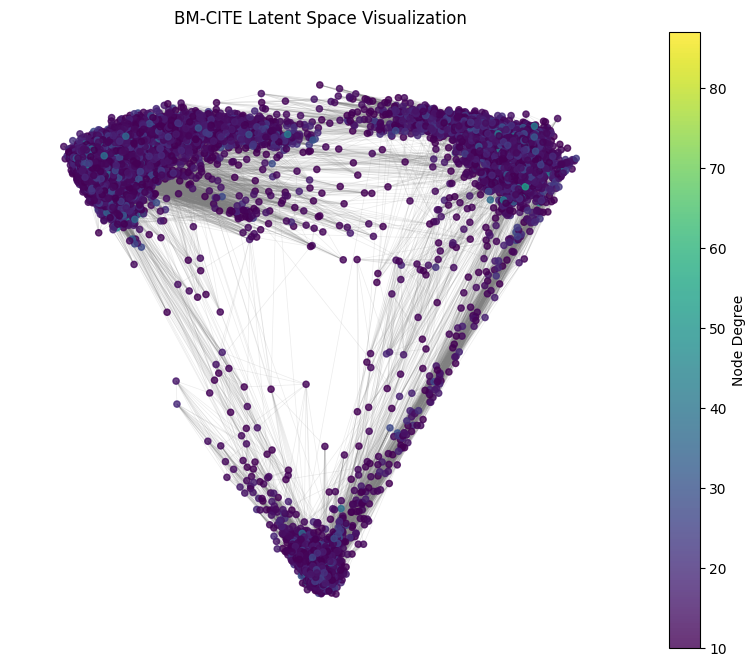

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.decomposition import PCA

# Assume z is your latent embedding (NumPy array or Torch tensor)
# If z is a torch tensor, convert to NumPy:
if torch.is_tensor(z):
    z = z.cpu().detach().numpy()

# Reduce to 2 dimensions for visualization (PCA can be replaced with UMAP for nonlinear reduction)
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)

# Create a NetworkX graph
G = nx.Graph()

num_nodes = z_2d.shape[0]
# Add nodes with 2D positions as attributes
for i in range(num_nodes):
    G.add_node(i, pos=z_2d[i])

# Use all edges from pos_edge_index (assumed to be a torch.LongTensor)
edge_index = pos_edge_index.cpu().numpy()  # shape: [2, num_edges]
num_edges = edge_index.shape[1]

# Add all edges to the graph
for i in range(num_edges):
    src, dst = edge_index[:, i]
    G.add_edge(int(src), int(dst))

# Get positions for all nodes and compute degrees for coloring
pos = nx.get_node_attributes(G, 'pos')
degree = dict(G.degree())
node_color = [degree[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
# Draw nodes with a colormap based on degree, which conveys importance or connectivity
nodes = nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_color, cmap=plt.cm.viridis, alpha=0.8)
edges = nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray', alpha=0.15)
plt.title("BM-CITE Latent Space Visualization")
plt.axis('off')
plt.colorbar(nodes, label='Node Degree')
plt.show()


In [35]:
latent_embedding = z
adata_eval = sc.AnnData(X=latent_embedding, obs=cell_metadata.copy())
adata_eval.obsm["emb"] = latent_embedding


c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


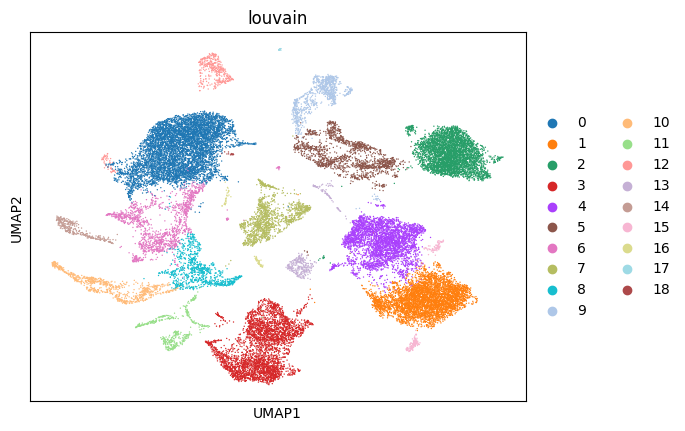

In [36]:
sc.pp.neighbors(adata_eval, use_rep='emb')         # Build neighbor graph using the latent embedding.
sc.tl.louvain(adata_eval, resolution=0.5)            # Run Louvain clustering.
sc.tl.umap(adata_eval)                               # Compute UMAP coordinates.
sc.pl.embedding(adata_eval, color='louvain', basis='umap')  # Visualize the UMAP colored by Louvain clusters.


In [37]:
try:
    gt = adata_eval.obs['celltype'].tolist()   # True labels.
except KeyError:
    gt = adata_eval.obs['cell_type'].tolist()
pred = adata_eval.obs['louvain'].tolist()     # Louvain cluster labels.

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from utils.eval_utils import compute_silhouette  

ari = adjusted_rand_score(gt, pred)
nmi = normalized_mutual_info_score(gt, pred)
silhouette = compute_silhouette(adata_eval, embedding_key="emb", cluster_key="louvain")

print("Adjusted Rand Index:", ari)
print("Normalized Mutual Information:", nmi)
print("Silhouette Score:", silhouette)

Adjusted Rand Index: 0.8913983849449721
Normalized Mutual Information: 0.8806588293450068
Silhouette Score: 0.28033316


In [ ]:
results_dir = "results"
metrics_dir = os.path.join(results_dir, "metrics")
figures_dir = os.path.join(results_dir, "figures")

os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

In [ ]:
metrics = {
    "dataset_name": DATASET_NAME,
    "in_channels": in_channels,
    "hidden_channels": hidden_channels,
    "latent_channels": latent_channels,
    "num_layers": num_layers,
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "ARI": ari,  
    "NMI": nmi   
}

In [ ]:
import pandas as pd

# Convert the metrics dictionary into a DataFrame and save as CSV.
df_metrics = pd.DataFrame([metrics])
csv_file = os.path.join(metrics_dir, f"{DATASET_NAME}_results.csv")
df_metrics.to_csv(csv_file, index=False)
print(f"Metrics saved to {csv_file}")

# Save the UMAP plot with Louvain clusters as a PNG.
# Re-run the plotting command with show=False to capture the figure.
sc.pl.embedding(adata_eval, color='louvain', basis='umap', show=False)
# Save the current figure.
umap_fig_path = os.path.join(figures_dir, "umap_louvain.png")
plt.savefig(umap_fig_path)
plt.close()
print(f"UMAP figure saved to {umap_fig_path}")

Metrics saved to results\metrics\10xPBMC_results.csv
UMAP figure saved to results\figures\umap_louvain.png


In [38]:
import torch
target_modality = "RNA"
target_features = torch.tensor(data[target_modality].X, dtype=torch.float)
output_dim = target_features.shape[1]
print(f"Predicting {target_modality} with output dim: {output_dim}")


Predicting RNA with output dim: 2000


In [44]:
from torch.utils.data import TensorDataset, DataLoader

z = torch.from_numpy(z)
# Create a dataset pairing the latent embeddings with the target modality features.
dataset = TensorDataset(z, target_features)
downstream_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [45]:
from downstream_tasks.downstream import DownstreamLightningModule
from pytorch_lightning import Trainer

# Instantiate the downstream Lightning module.
downstream_model = DownstreamLightningModule(latent_channels=z.shape[1], output_dim=output_dim, learning_rate=1e-3)

# Train the predictor
downstream_trainer = Trainer(max_epochs=50, accelerator="gpu", devices=1)
downstream_trainer.fit(downstream_model, train_dataloaders=downstream_loader, val_dataloaders=downstream_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode 
-----------------

c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 120/120 [00:04<00:00, 28.16it/s, v_num=9, train_loss=0.625, val_loss=0.624]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 120/120 [00:04<00:00, 27.83it/s, v_num=9, train_loss=0.625, val_loss=0.624]


In [46]:
import torch.nn.functional as F
import numpy as np
from scipy.stats import pearsonr

downstream_model.eval()
with torch.no_grad():
    predictions = downstream_model(z.cpu())  # Shape: [num_cells, output_dim]
    mse_loss = F.mse_loss(predictions, target_features)
    rmse = torch.sqrt(mse_loss)
print(f"Downstream Cross-Modal Prediction RMSE: {rmse.item():.4f}")

# Convert predictions and targets to numpy arrays for PCC calculations.
pred_np = predictions.cpu().numpy().flatten()
target_np = target_features.cpu().numpy().flatten()

# Compute Pearson Correlation Coefficient (PCC)
pcc, _ = pearsonr(pred_np, target_np)
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

Downstream Cross-Modal Prediction RMSE: 0.7898
Pearson Correlation Coefficient: 0.4047


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

sns.set_theme(style="whitegrid", font_scale=1.1)

dataset = DATASET_NAME
modality = target_modality
save_path = f"results/figures/cross-modality/{dataset}/{modality}/"
os.makedirs(save_path, exist_ok=True)

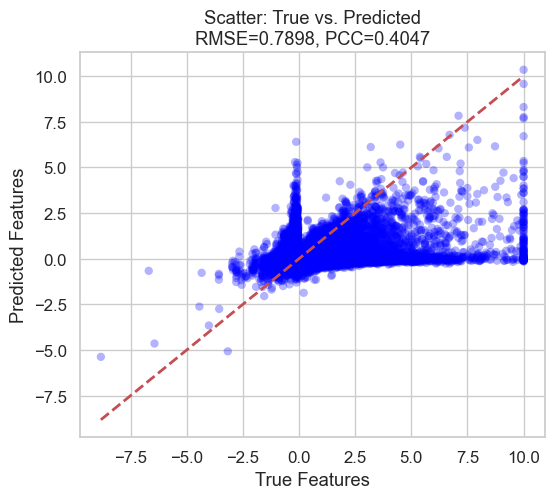

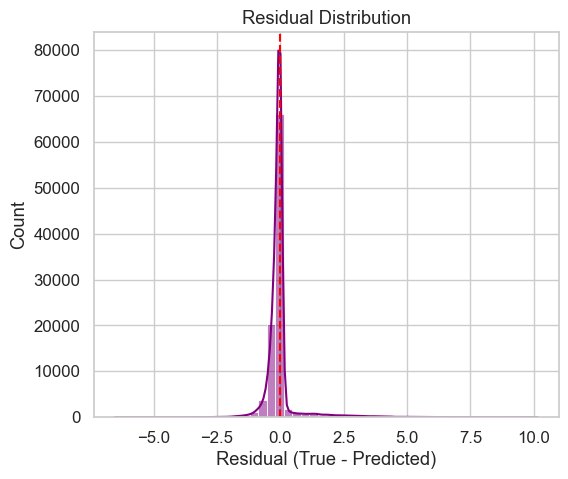

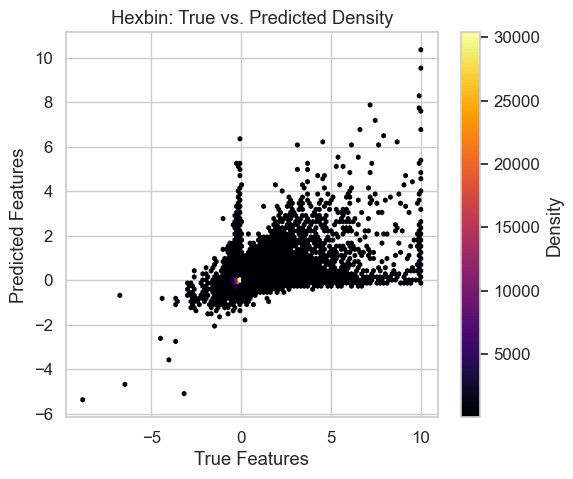

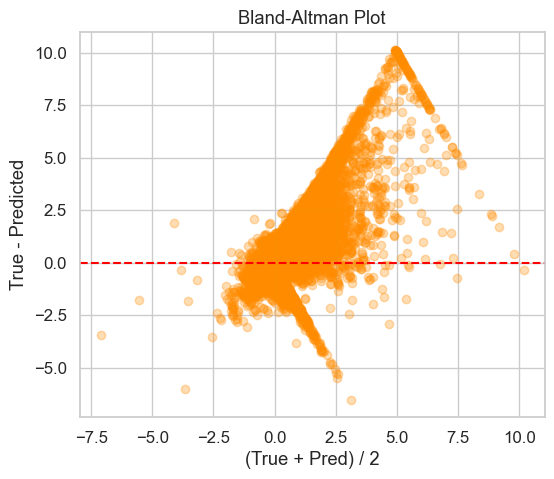

In [57]:
# Downsample data
sample_size = min(100000, len(target_np))  
step = len(target_np) // sample_size  
target_sampled = target_np[::step]  
pred_sampled = pred_np[::step]  
residuals = target_sampled - pred_sampled  
mean_values = 0.5 * (target_sampled + pred_sampled)
diff_values = target_sampled - pred_sampled

plt.figure(figsize=(6, 5))
plt.scatter(target_sampled, pred_sampled, alpha=0.3, color="blue", edgecolors="none")
plt.plot([target_np.min(), target_np.max()], [target_np.min(), target_np.max()], 'r--', linewidth=2)
plt.xlabel("True Features")
plt.ylabel("Predicted Features")
plt.title(f"Scatter: True vs. Predicted\nRMSE={rmse:.4f}, PCC={pcc:.4f}")
plt.show()

plt.figure(figsize=(6, 5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (True - Predicted)")
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(6, 5))
hb = plt.hexbin(target_sampled, pred_sampled, gridsize=100, cmap="inferno", mincnt=1)
plt.colorbar(label="Density")
plt.xlabel("True Features")
plt.ylabel("Predicted Features")
plt.title("Hexbin: True vs. Predicted Density")
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(mean_values, diff_values, alpha=0.3, color="darkorange")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("(True + Pred) / 2")
plt.ylabel("True - Predicted")
plt.title("Bland-Altman Plot")
plt.show()


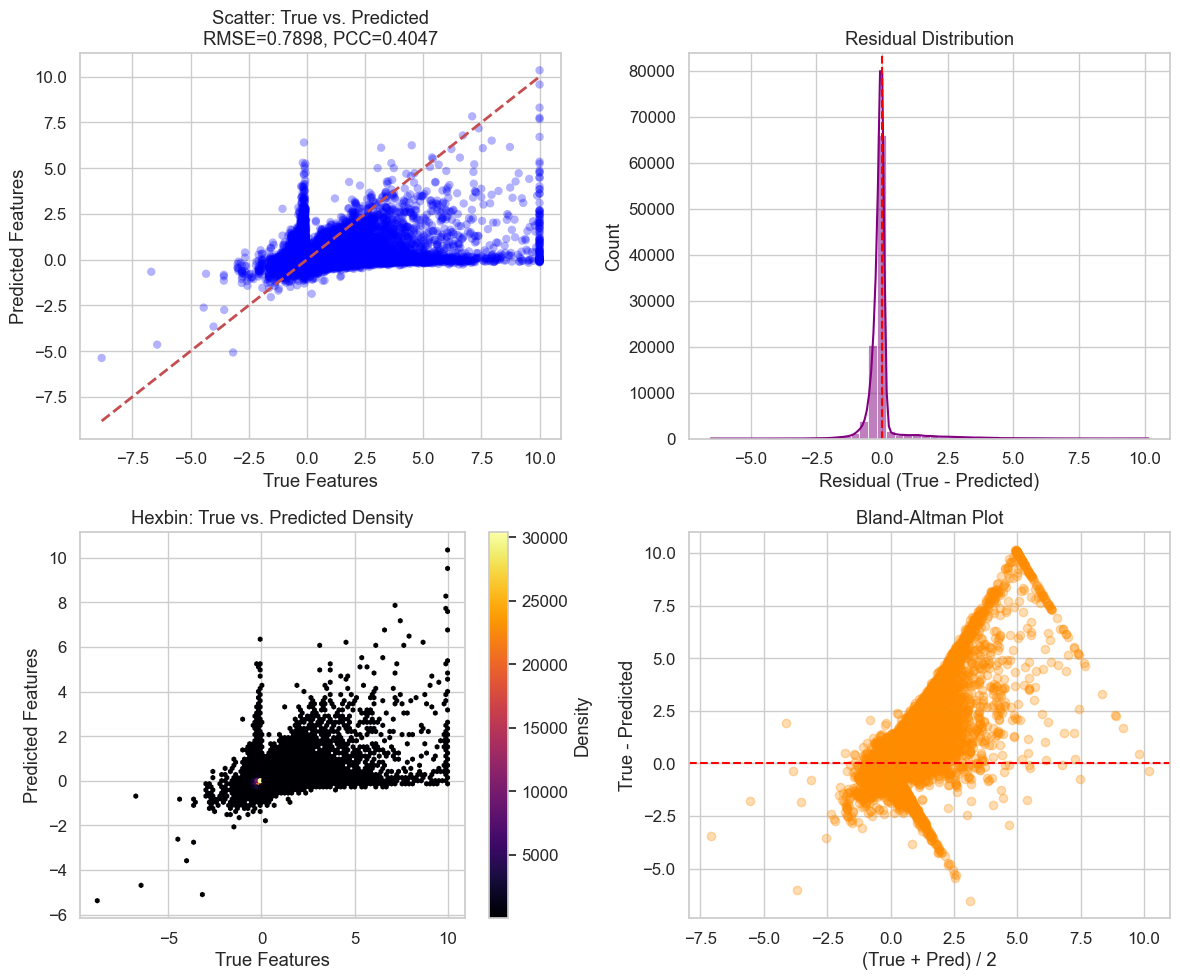

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Scatter Plot
axes[0].scatter(target_sampled, pred_sampled, alpha=0.3, color="blue", edgecolors="none")
axes[0].plot([target_np.min(), target_np.max()], [target_np.min(), target_np.max()], 'r--', linewidth=2)
axes[0].set_xlabel("True Features")
axes[0].set_ylabel("Predicted Features")
axes[0].set_title(f"Scatter: True vs. Predicted\nRMSE={rmse:.4f}, PCC={pcc:.4f}")

# Residual Histogram
sns.histplot(residuals, bins=50, kde=True, ax=axes[1], color="purple")
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel("Residual (True - Predicted)")
axes[1].set_title("Residual Distribution")

# Hexbin Density Plot
hb = axes[2].hexbin(target_sampled, pred_sampled, gridsize=100, cmap="inferno", mincnt=1)
fig.colorbar(hb, ax=axes[2], label="Density")
axes[2].set_xlabel("True Features")
axes[2].set_ylabel("Predicted Features")
axes[2].set_title("Hexbin: True vs. Predicted Density")

# Bland-Altman Plot
axes[3].scatter(mean_values, diff_values, alpha=0.3, color="darkorange")
axes[3].axhline(0, color='red', linestyle='--')
axes[3].set_xlabel("(True + Pred) / 2")
axes[3].set_ylabel("True - Predicted")
axes[3].set_title("Bland-Altman Plot")

plt.tight_layout()
plt.savefig(f"{save_path}all_plots_combined.png", dpi=300)
plt.show()